**Project Tasks → Notebook Cell Mapping**

- **Overview & Leakage Rules**: Cell 4 — explains the project goals, leakage-safe principles, and the roadmap for the notebook.
- **Setup & Imports**: Cell 5 — creates the Spark session, imports plotting libraries (matplotlib/seaborn optional), and defines helper functions.
- **Data Loading & Leakage-Safe Feature Engineering**: Cell 6 — loads the CSV, parses `order date (DateOrders)` into timestamps and derives `order_hour`, `order_dow`, `order_month`, computes `discount_ratio`, and selects only columns available at order time.
- **EDA Summary**: Cell 7 — class balance, top null counts for safe columns, and sample rows to inspect data quality.
- **Visualizations (EDA)**: Cell 8 — correlation heatmap for numeric features and late-rate bar plots for key categorical features (e.g., `Shipping Mode`, `Order Region`).
- **Preprocessing + Class Weights**: Cell 9 — numeric imputation (median), categorical `StringIndexer` + `OneHotEncoder`, `VectorAssembler` + `StandardScaler`, and computation of a `weightCol` to mitigate label imbalance.
- **Train / Test, Cross-Validation & Metrics**: Cell 10 — 80/20 split, CrossValidator with RandomForest (uses `weightCol`), evaluation on test set with AUC, accuracy, precision, recall and F1, plus confusion matrix.
- **Feature Importances**: Cell 11 — extract RandomForest feature importances, aggregate OHE columns back to original feature names and show top contributors.
- **Save Model & Metrics**: Cell 12 — saves the best pipeline model to `/src/models/late_delivery_pipeline_safe` and writes test metrics to `/src/models/metrics.json`.

How to use this map:
- Run the cells in the listed order (4 → 12) to follow the full leakage-safe pipeline.
- If you prefer, run the EDA/Visuals first (Cells 7–8) to explore before training.
- Ask me to collapse or remove the older, pre-leakage-safe cells if you want a single linear flow.

### Start Here: Leakage-Safe Batch Pipeline (Cells 5–13)
- 5: Setup & imports
- 6: Data loading + leakage-safe features
- 7: EDA summary
- 8: Visuals (correlations, late-rate)
- 9: Preprocessing + class weights
- 10: Train/test + CV + metrics
- 11: Feature importances
- 12: Save best model + metrics

### Legacy Prototype (Cells 2–4)
Kept for reference only. Prefer the leakage-safe pipeline above.

In [ ]:
# # # ===== Cell 1: EDA + Initial Preparation =====
# # Task 1: Chargement et Préparation des Données (import + basic transformations)
# from pyspark.sql import SparkSession
# # Task 2: Analyse Exploratoire des Données (functions used for stats/correlations)
# from pyspark.sql.functions import col, to_timestamp, regexp_replace, when, count, avg, expr

# # Task 1: Spark session creation (environment setup)
# spark = SparkSession.builder.appName("eda-logistique").getOrCreate()

# # Task 1: Data loading (CSV import with schema inference)
# df = spark.read.csv("/src/data/DataCoSupplyChainDataset.csv", header=True, inferSchema=True, encoding="ISO-8859-1")

# # Task 1: Date parsing (transformation for data quality)
# df = (df
#       .withColumn("order_ts", to_timestamp(col("order date (DateOrders)"), "M/d/yyyy H:mm"))
#       .withColumn("ship_ts", to_timestamp(col("shipping date (DateOrders)"), "M/d/yyyy H:mm"))
#      )

# # Task 1: Feature engineering (shipping_delay_days, discount_ratio, profit_margin_ratio)
# df = df.withColumn("shipping_delay_days",
#                    col("Days for shipping (real)") - col("Days for shipment (scheduled)"))

# df = df.withColumn("discount_ratio",
#                    when(col("Order Item Product Price") > 0,
#                         col("Order Item Discount") / col("Order Item Product Price"))
#                    .otherwise(0))

# df = df.withColumn("profit_margin_ratio",
#                    when(col("Sales") > 0, col("Order Profit Per Order") / col("Sales")).otherwise(0))

# # Task 2: Null value overview (identifying data quality issues)
# nulls = (df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
#            .toPandas().T.sort_values(by=0, ascending=False).head(15))
# print("Top null counts:\n", nulls)

# # Task 2: Target class balance (distribution of Late_delivery_risk)
# class_balance = df.groupBy("Late_delivery_risk").count().orderBy("Late_delivery_risk")
# class_balance.show()

# # Task 2: Basic descriptive statistic (mean of engineered feature)
# df.select(avg("shipping_delay_days").alias("avg_shipping_delay")).show()

# # Task 2: Univariate stats (profit describe)
# df.select("Order Profit Per Order").describe().show()

# # Task 2: Simple correlation check (example predictive relationship)
# corr_val = df.stat.corr("shipping_delay_days", "discount_ratio")
# print("Corr(shipping_delay_days, discount_ratio):", corr_val)

# # Task 2: Sample preview (sanity check on engineered + categorical fields)
# df.select("Late_delivery_risk","shipping_delay_days","discount_ratio","profit_margin_ratio",
#           "Order Region","Shipping Mode").show(10, truncate=False)

# # ===== Cell 2: ML Pipeline Construction & Partial Preprocessing =====
# # Task 3: Prétraitement (start) – importing ML components
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# # Task 4: Pipeline environment (new Spark session for training context)
# spark = SparkSession.builder.appName("train-late-delivery").getOrCreate()

# # Task 1 (repeat for training context): Load raw data
# df = spark.read.csv("/src/data/DataCoSupplyChainDataset.csv", header=True, inferSchema=True, encoding="ISO-8859-1")

# # Task 1: Recreate engineered feature needed for modeling
# df = df.withColumn("shipping_delay_days",
#                    col("Days for shipping (real)") - col("Days for shipment (scheduled)"))

# # Task 4: Label + feature selection (defining modeling dataset)
# data = df.select(
#     col("Late_delivery_risk").cast("int").alias("label"),
#     "Shipping Mode",
#     "Order Region",
#     "Order Item Quantity",
#     "Order Item Product Price",
#     "Order Item Discount",
#     "Order Profit Per Order",
#     "Days for shipping (real)",
#     "Days for shipment (scheduled)",
#     "shipping_delay_days"
# ).dropna()  # Task 3: crude missing value handling (dropna)

# # Task 3: Identify categorical vs numeric columns (input segregation)
# cat_cols = ["Shipping Mode", "Order Region"]
# num_cols = [c for c in data.columns if c not in cat_cols + ["label"]]

# # Task 3: Categorical encoding (StringIndexer + OneHotEncoder)
# indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
# encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_oh") for c in cat_cols]

# # Task 3: Feature assembly (VectorAssembler) and scaling (StandardScaler)
# assembler = VectorAssembler(
#     inputCols=[f"{c}_oh" for c in cat_cols] + num_cols,
#     outputCol="features_raw"
# )
# scaler = StandardScaler(inputCol="features_raw", outputCol="features")

# # Task 4: Model definition (RandomForestClassifier)
# rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# # Task 4: Full MLlib Pipeline (preprocessing + model)
# pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, rf]) 

# # Task 5: Hyperparameter search space (param grid for model selection)
# param_grid = (ParamGridBuilder()
#               .addGrid(rf.numTrees, [50, 100])
#               .addGrid(rf.maxDepth, [5, 10])
#               .build())

# # Task 5: Evaluation metric (ROC AUC) – (other metrics not yet added)
# evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="label")

# # Task 5: Cross-validation setup (model comparison/selection)
# cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid,
#                     evaluator=evaluator, numFolds=3)

# # Task 5: Fit cross-validated model
# model = cv.fit(data)

# # Task 5: AUC printed (currently on training transform; no separate test split yet)
# print("ROC AUC:", evaluator.evaluate(model.transform(data)))

# # Task 6: Model persistence (saved pipeline for later deployment)
# model.bestModel.write().overwrite().save("/src/models/late_delivery_pipeline")

# # ---- Gaps relative to tasks ----
# # Task 3 missing: Imputation strategy, class balancing (weightCol/SMOTE).
# # Task 5 missing: accuracy, precision, recall, F1, test split.
# # Task 6 missing: Streamlit integration/loading endpoint.

In [ ]:
# # from pyspark.sql import SparkSession
# from pyspark.sql.functions import col, to_timestamp, regexp_replace, when, count, avg, expr

# spark = SparkSession.builder.appName("eda-logistique").getOrCreate()
# df = spark.read.csv("/src/data/DataCoSupplyChainDataset.csv", header=True, inferSchema=True, encoding="ISO-8859-1")

# # Dates to timestamp (keep original names if needed)
# df = (df
#       .withColumn("order_ts", to_timestamp(col("order date (DateOrders)"), "M/d/yyyy H:mm"))
#       .withColumn("ship_ts", to_timestamp(col("shipping date (DateOrders)"), "M/d/yyyy H:mm"))
#      )

# # Basic engineered features
# df = df.withColumn("shipping_delay_days",
#                    col("Days for shipping (real)") - col("Days for shipment (scheduled)"))

# df = df.withColumn("discount_ratio",
#                    when(col("Order Item Product Price") > 0,
#                         col("Order Item Discount") / col("Order Item Product Price"))
#                    .otherwise(0))

# df = df.withColumn("profit_margin_ratio",
#                    when(col("Sales") > 0, col("Order Profit Per Order") / col("Sales")).otherwise(0))

# # Null counts (top 15)
# nulls = (df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
#            .toPandas().T.sort_values(by=0, ascending=False).head(15))
# print("Top null counts:\n", nulls)

# # Class balance
# class_balance = df.groupBy("Late_delivery_risk").count().orderBy("Late_delivery_risk")
# class_balance.show()

# # Shipping delay stats
# df.select(avg("shipping_delay_days").alias("avg_shipping_delay")).show()

# # Profit distribution sample
# df.select("Order Profit Per Order").describe().show()

# # Correlation (example: delay vs discount ratio)
# corr_val = df.stat.corr("shipping_delay_days", "discount_ratio")
# print("Corr(shipping_delay_days, discount_ratio):", corr_val)

# # Sample rows
# df.select("Late_delivery_risk","shipping_delay_days","discount_ratio","profit_margin_ratio",
#           "Order Region","Shipping Mode").show(10, truncate=False)

In [ ]:
# # from pyspark.sql import SparkSession
# from pyspark.sql.functions import col
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# spark = SparkSession.builder.appName("train-late-delivery").getOrCreate()
# df = spark.read.csv("/src/data/DataCoSupplyChainDataset.csv", header=True, inferSchema=True, encoding="ISO-8859-1")

# df = df.withColumn("shipping_delay_days",
#                    col("Days for shipping (real)") - col("Days for shipment (scheduled)"))

# # Label
# data = df.select(
#     col("Late_delivery_risk").cast("int").alias("label"),
#     "Shipping Mode",
#     "Order Region",
#     "Order Item Quantity",
#     "Order Item Product Price",
#     "Order Item Discount",
#     "Order Profit Per Order",
#     "Days for shipping (real)",
#     "Days for shipment (scheduled)",
#     "shipping_delay_days"
# ).dropna()

# cat_cols = ["Shipping Mode", "Order Region"]
# num_cols = [c for c in data.columns if c not in cat_cols + ["label"]]

# indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
# encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_oh") for c in cat_cols]

# assembler = VectorAssembler(
#     inputCols=[f"{c}_oh" for c in cat_cols] + num_cols,
#     outputCol="features_raw"
# )
# scaler = StandardScaler(inputCol="features_raw", outputCol="features")
# rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, rf])

# param_grid = (ParamGridBuilder()
#               .addGrid(rf.numTrees, [50, 100])
#               .addGrid(rf.maxDepth, [5, 10])
#               .build())

# evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="label")
# cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid,
#                     evaluator=evaluator, numFolds=3)

# model = cv.fit(data)
# print("ROC AUC:", evaluator.evaluate(model.transform(data)))
# model.bestModel.write().overwrite().save("/src/models/late_delivery_pipeline")

# Project Roadmap and Leakage-Safe Plan

This section adds a clean, task-by-task implementation that avoids target leakage for predicting late deliveries.

Tasks covered (each has its own cell):
1. Setup and Principles (why we exclude leakage columns)
2. Data Loading and Leakage-Safe Feature Engineering
3. EDA Summary (class balance, nulls, samples)
4. Visuals (correlations + categorical late-rate plots)
5. Preprocessing Pipeline (imputation, encoding, assembly) + Class Weights
6. Train/Test Split, Cross-Validation, and Metrics (AUC, accuracy, precision, recall, F1)
7. Feature Importances (grouped by original features)
8. Save Best Model and Metrics

Reference time: we use the promised lead time `Days for shipment (scheduled)` and order timestamp parts; we DO NOT use any post-order outcome fields (e.g., `Days for shipping (real)`, `Delivery Status`, `shipping date (DateOrders)`).

In [1]:
# === Task 1: Setup and Principles ===
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, to_timestamp, when, month, dayofweek, hour, count, avg
)
from pyspark.sql import functions as F

# Plotting (optional; fall back gracefully if missing)

import seaborn as sns

import matplotlib.pyplot as plt


spark = SparkSession.builder.appName("late-delivery-safe").getOrCreate()
spark.sparkContext.setLogLevel("WARN")
spark.conf.set("spark.sql.shuffle.partitions", "64")

def safe_to_pandas(df, limit=5000):
    return df.limit(limit).toPandas()

print("Spark ready. Proceeding with leakage-safe pipeline.")

/opt/spark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/01 19:19:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/01 19:19:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/opt/spark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/01 19:19:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/01 19:19:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark ready. Proceeding with leakage-safe pipeline.


In [2]:
path = "/src/data/DataCoSupplyChainDataset.csv"
raw = spark.read.csv(path, header=True, inferSchema=True, encoding="ISO-8859-1")

#raw.select('order date (DateOrders)').show(3, truncate=False)
raw.printSchema(50)


root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

In [9]:


raw.printSchema()
raw.select("order date (DateOrders)").show(6, truncate=False)

from pyspark.sql.functions import trim, to_timestamp, hour, dayofweek, month, col

parsed = raw.withColumn("order_ts", to_timestamp(trim(col("order date (DateOrders)")), "M/d/yyyy H:mm"))

# before / after sample
parsed.select("order date (DateOrders)", "order_ts").show(8, truncate=False)

# extracted parts
parsed.select(
    "order date (DateOrders)",
    "order_ts",
    hour(col("order_ts")).alias("order_hour"),
    dayofweek(col("order_ts")).alias("order_dow"),
    month(col("order_ts")).alias("order_month")
).show(8, truncate=False)

# show parse failures (non-null source but null parsed ts)
parsed.filter(col("order date (DateOrders)").isNotNull() & col("order_ts").isNull()).show(10, truncate=False)
# ...existing code...

data path: /src/data/DataCoSupplyChainDataset.csv
Likely HDFS/S3? -> False
root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer 

In [4]:
df = raw.withColumn(
    "order_ts", to_timestamp(col("order date (DateOrders)"), "M/d/yyyy H:mm")
)
df.show(30)

25/11/26 14:08:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


25/11/26 14:08:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+-------------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Be

In [6]:
from pyspark.sql.functions import col, when, abs

# show types
print("dtypes (sample):", dict(df.dtypes).get("Order Item Discount Rate"), dict(df.dtypes).get("discount_ratio_double"))
df.select("Order Item Discount Rate").printSchema()
df.select("discount_ratio_double").printSchema()

# compute ratio from discount and price (per-unit)
df = df.withColumn(
    "computed_ratio",
    when(col("Order Item Product Price") > 0,
         col("Order Item Discount") / col("Order Item Product Price")).otherwise(None)
)

# side-by-side sample
df.select("Order Item Discount Rate", "discount_ratio_double", "computed_ratio").show(10, truncate=False)

# show rows where existing rate differs from computed_ratio by > 1e-6
diffs = df.filter(col("discount_ratio_double").isNotNull() & col("computed_ratio").isNotNull() &
                  (abs(col("discount_ratio_double") - col("computed_ratio")) > 1e-6))
print("Count of differing rows:", diffs.count())
diffs.select("Order Id", "Order Item Product Price", "Order Item Discount",
             "discount_ratio_double", "computed_ratio").show(10, truncate=False)

dtypes (sample): double double
root
 |-- Order Item Discount Rate: double (nullable = true)

root
 |-- discount_ratio_double: double (nullable = true)

+------------------------+---------------------+-------------------+
|Order Item Discount Rate|discount_ratio_double|computed_ratio     |
+------------------------+---------------------+-------------------+
|0.039999999             |0.039999999          |0.03999999896262395|
|0.050000001             |0.050000001          |0.05000762590389016|
|0.059999999             |0.059999999          |0.05501144375286041|
|0.07                    |0.07                 |0.06999237385202135|
|0.090000004             |0.090000004          |0.09000762776506484|
|0.100000001             |0.100000001          |0.10001525180778031|
|0.119999997             |0.119999997          |0.12000000558352403|
|0.129999995             |0.129999995          |0.13000762962623952|
|0.150000006             |0.150000006          |0.14999237177726926|
|0.159999996        

dtypes (sample): double double
root
 |-- Order Item Discount Rate: double (nullable = true)

root
 |-- discount_ratio_double: double (nullable = true)

+------------------------+---------------------+-------------------+
|Order Item Discount Rate|discount_ratio_double|computed_ratio     |
+------------------------+---------------------+-------------------+
|0.039999999             |0.039999999          |0.03999999896262395|
|0.050000001             |0.050000001          |0.05000762590389016|
|0.059999999             |0.059999999          |0.05501144375286041|
|0.07                    |0.07                 |0.06999237385202135|
|0.090000004             |0.090000004          |0.09000762776506484|
|0.100000001             |0.100000001          |0.10001525180778031|
|0.119999997             |0.119999997          |0.12000000558352403|
|0.129999995             |0.129999995          |0.13000762962623952|
|0.150000006             |0.150000006          |0.14999237177726926|
|0.159999996        

dtypes (sample): double double
root
 |-- Order Item Discount Rate: double (nullable = true)

root
 |-- discount_ratio_double: double (nullable = true)

+------------------------+---------------------+-------------------+
|Order Item Discount Rate|discount_ratio_double|computed_ratio     |
+------------------------+---------------------+-------------------+
|0.039999999             |0.039999999          |0.03999999896262395|
|0.050000001             |0.050000001          |0.05000762590389016|
|0.059999999             |0.059999999          |0.05501144375286041|
|0.07                    |0.07                 |0.06999237385202135|
|0.090000004             |0.090000004          |0.09000762776506484|
|0.100000001             |0.100000001          |0.10001525180778031|
|0.119999997             |0.119999997          |0.12000000558352403|
|0.129999995             |0.129999995          |0.13000762962623952|
|0.150000006             |0.150000006          |0.14999237177726926|
|0.159999996        

Count of differing rows: 159090
+--------+------------------------+-------------------+---------------------+-------------------+
|Order Id|Order Item Product Price|Order Item Discount|discount_ratio_double|computed_ratio     |
+--------+------------------------+-------------------+---------------------+-------------------+
|75939   |327.75                  |16.38999939        |0.050000001          |0.05000762590389016|
|75938   |327.75                  |18.03000069        |0.059999999          |0.05501144375286041|
|75937   |327.75                  |22.94000053        |0.07                 |0.06999237385202135|
|75936   |327.75                  |29.5               |0.090000004          |0.09000762776506484|
|75935   |327.75                  |32.77999878        |0.100000001          |0.10001525180778031|
|75933   |327.75                  |42.61000061        |0.129999995          |0.13000762962623952|
|75932   |327.75                  |49.15999985        |0.150000006          |0.1499923

In [7]:
# === Task 2: Data Loading + Leakage-Safe Feature Engineering ===
path = "/src/data/DataCoSupplyChainDataset.csv"
raw = spark.read.csv(path, header=True, inferSchema=True, encoding="ISO-8859-1")

# Parse order timestamp (known at order time)
df = raw.withColumn(
    "order_ts", to_timestamp(col("order date (DateOrders)"), "M/d/yyyy H:mm")
)

# Time parts
df = (df
      .withColumn("order_hour", hour(col("order_ts")))
      .withColumn("order_dow", dayofweek(col("order_ts")))  # 1=Sunday ... 7=Saturday
      .withColumn("order_month", month(col("order_ts")))
     )

# Price/discount ratio (guard divide by zero) so we get the absolute price after discount
df = df.withColumn(
    "discount_ratio",
    when(col("Order Item Product Price") > 0,
         col("Order Item Discount") / col("Order Item Product Price")).otherwise(0.0)
)

# Label (binary)
df = df.withColumn("label", col("Late_delivery_risk").cast("int"))

# Select leakage-safe columns only (available at order creation)
safe_cols_cat = [
    "Shipping Mode", "Market", "Order Region", "Customer Segment",
    "Department Id", "Category Id", "Product Category Id"
]
safe_cols_num = [
    "Days for shipment (scheduled)", "Order Item Quantity", "Order Item Product Price",
    "Order Item Discount", "discount_ratio", "Latitude", "Longitude",
    "order_hour", "order_dow", "order_month"
]
leakage_cols = [
    "Days for shipping (real)", "shipping date (DateOrders)", "Delivery Status",
    "Order Status", "Order Profit Per Order", "Benefit per order",
    "Order Item Profit Ratio", "order date (DateOrders)"
]

safe_select = ["label"] + safe_cols_cat + safe_cols_num

df_safe = df.select(*safe_select)
df_safe = df_safe.cache()
print("Loaded rows:", df_safe.count())
print("Safe columns:", df_safe.columns)

Loaded rows: 180519
Safe columns: ['label', 'Shipping Mode', 'Market', 'Order Region', 'Customer Segment', 'Department Id', 'Category Id', 'Product Category Id', 'Days for shipment (scheduled)', 'Order Item Quantity', 'Order Item Product Price', 'Order Item Discount', 'discount_ratio', 'Latitude', 'Longitude', 'order_hour', 'order_dow', 'order_month']


In [8]:
df.select('discount_ratio','Order Item Discount Rate').show(8)

+-------------------+------------------------+
|     discount_ratio|Order Item Discount Rate|
+-------------------+------------------------+
|0.03999999896262395|             0.039999999|
|0.05000762590389016|             0.050000001|
|0.05501144375286041|             0.059999999|
|0.06999237385202135|                    0.07|
|0.09000762776506484|             0.090000004|
|0.10001525180778031|             0.100000001|
|0.12000000558352403|             0.119999997|
|0.13000762962623952|             0.129999995|
+-------------------+------------------------+
only showing top 8 rows



In [17]:
# === Task 3: EDA Summary (class balance, nulls, samples) ===
# Class balance
class_balance = df_safe.groupBy("label").count().orderBy("label")
class_balance.show()

# Top null counts across safe columns
null_exprs = [F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_safe.columns]
nulls_df = df_safe.select(null_exprs)
nulls_pd = nulls_df.toPandas().T.sort_values(by=0, ascending=False)
print("Top null counts (safe cols):\n", nulls_pd.head(15))

# Sample rows (leakage-safe columns only)
df_safe.select(
    "label", "Shipping Mode", "Order Region", "Market", "Customer Segment",
    "Days for shipment (scheduled)", "Order Item Quantity", "Order Item Product Price",
    "Order Item Discount", "discount_ratio", "order_hour", "order_dow", "order_month"
).show(10, truncate=False)
df_safe.show(10, truncate=False)

+-----+-----+
|label|count|
+-----+-----+
|    0|81542|
|    1|98977|
+-----+-----+

Top null counts (safe cols):
                                0
label                          0
Shipping Mode                  0
Market                         0
Order Region                   0
Customer Segment               0
Department Id                  0
Category Id                    0
Product Category Id            0
Days for shipment (scheduled)  0
Order Item Quantity            0
Order Item Product Price       0
Order Item Discount            0
discount_ratio                 0
Latitude                       0
Longitude                      0
Top null counts (safe cols):
                                0
label                          0
Shipping Mode                  0
Market                         0
Order Region                   0
Customer Segment               0
Department Id                  0
Category Id                    0
Product Category Id            0
Days for shipment (scheduled) 

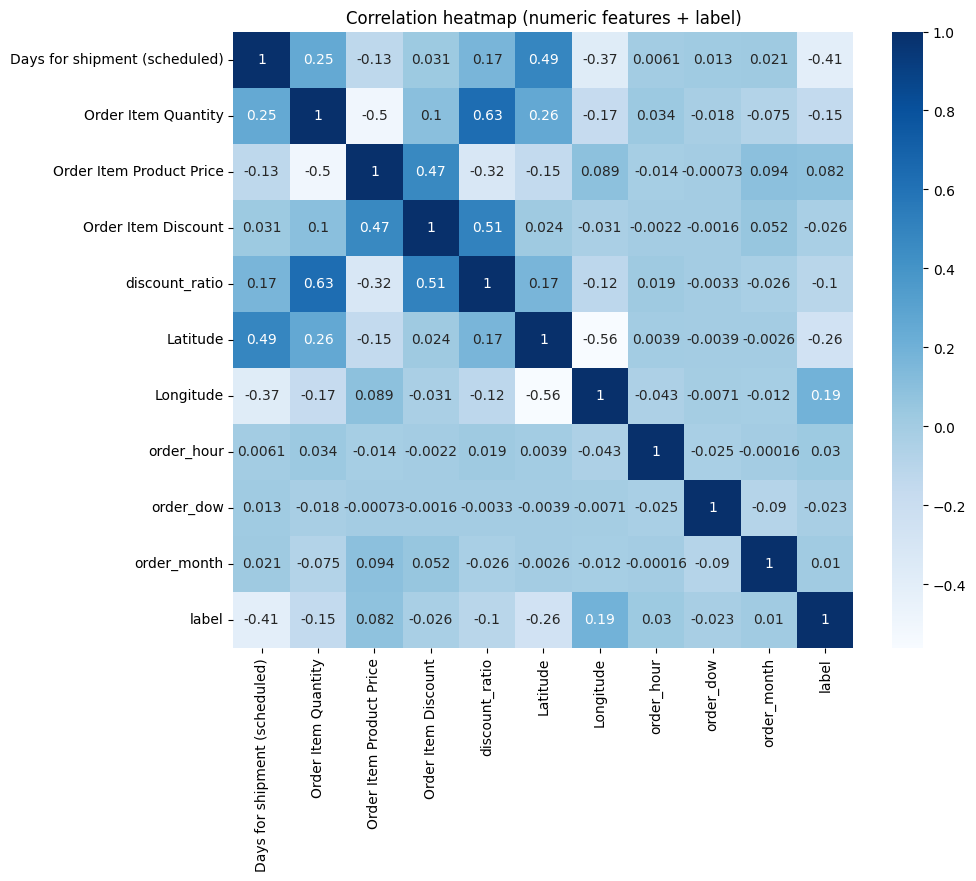

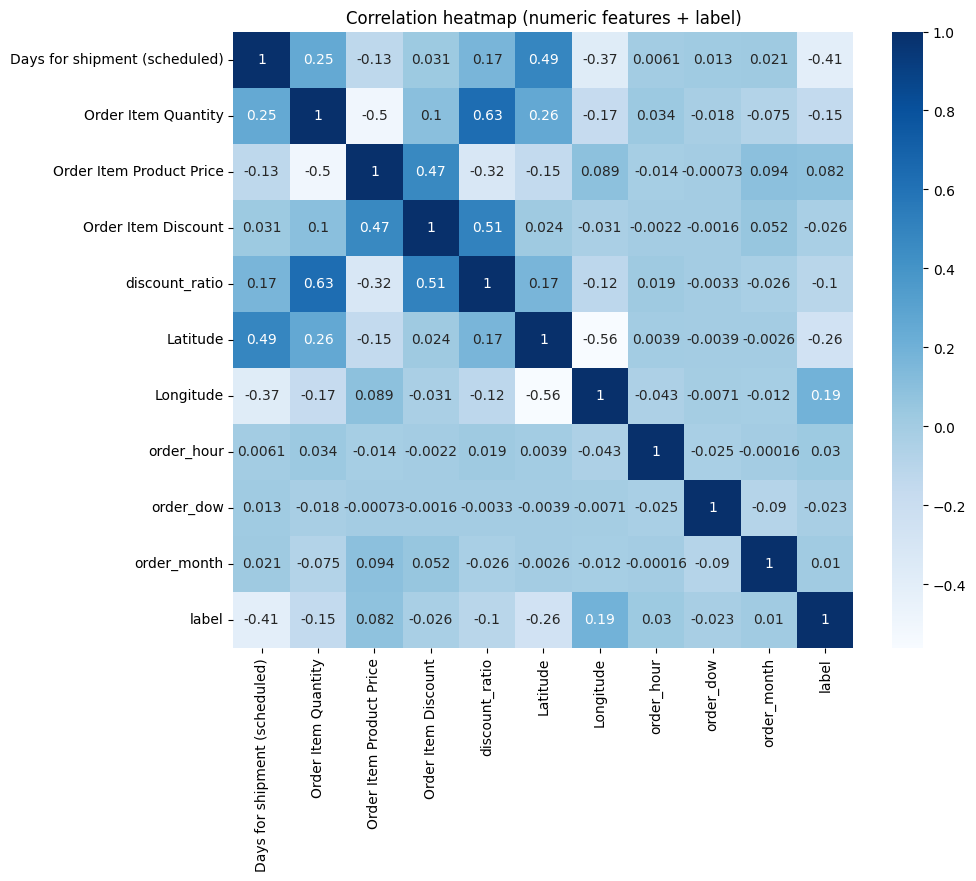

Late rate by Shipping Mode (top):
     Shipping Mode  late_rate
0     First Class   0.953225
1    Second Class   0.766328
2        Same Day   0.457430
3  Standard Class   0.380717
Plot error for Shipping Mode: xlabel() missing 1 required positional argument: 'xlabel'
Late rate by Order Region (top):
      Order Region  late_rate
0  Central Africa   0.579606
1      South Asia   0.562670
2     East Africa   0.559395
3  Western Europe   0.558486
4  South of  USA    0.557726
Plot error for Order Region: xlabel() missing 1 required positional argument: 'xlabel'


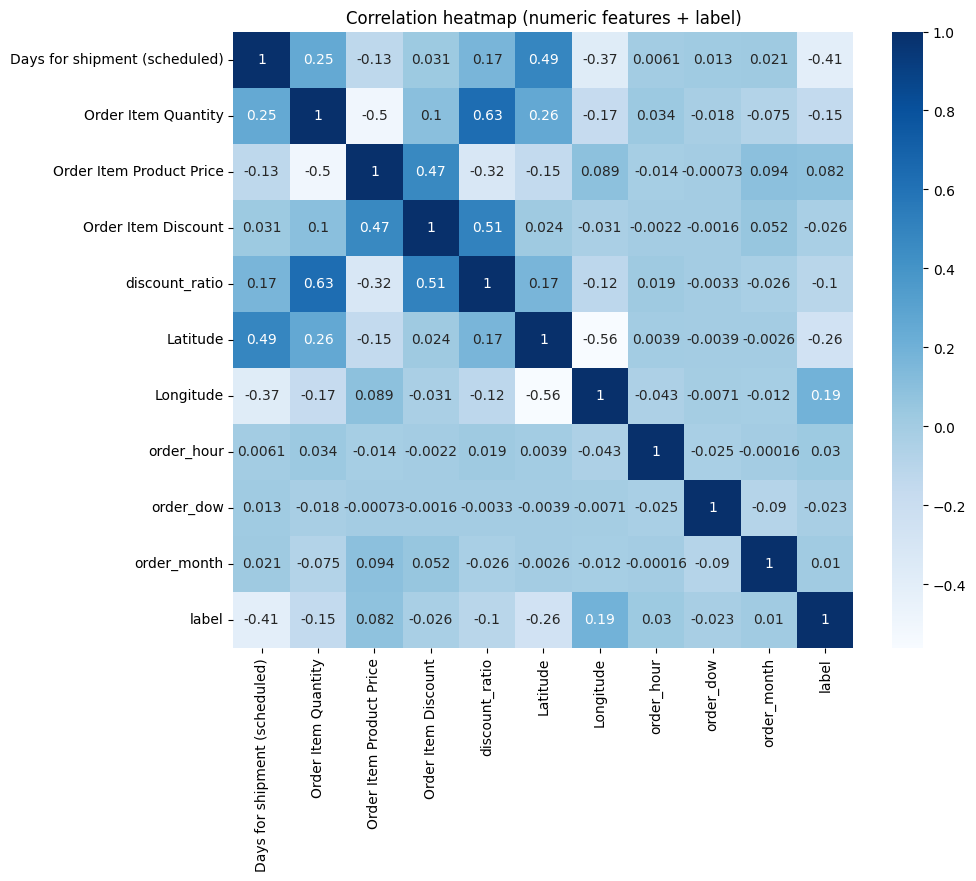

Late rate by Shipping Mode (top):
     Shipping Mode  late_rate
0     First Class   0.953225
1    Second Class   0.766328
2        Same Day   0.457430
3  Standard Class   0.380717
Plot error for Shipping Mode: xlabel() missing 1 required positional argument: 'xlabel'
Late rate by Order Region (top):
      Order Region  late_rate
0  Central Africa   0.579606
1      South Asia   0.562670
2     East Africa   0.559395
3  Western Europe   0.558486
4  South of  USA    0.557726
Plot error for Order Region: xlabel() missing 1 required positional argument: 'xlabel'


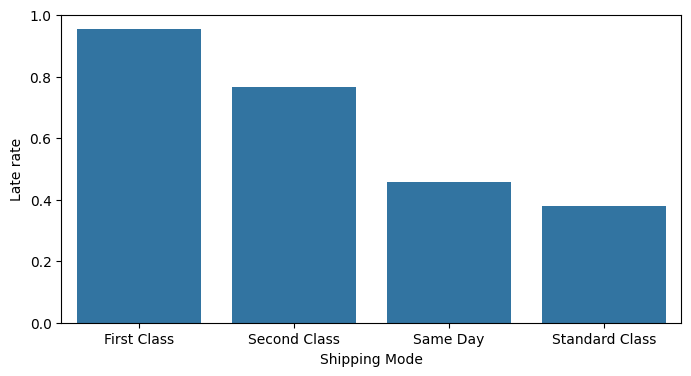

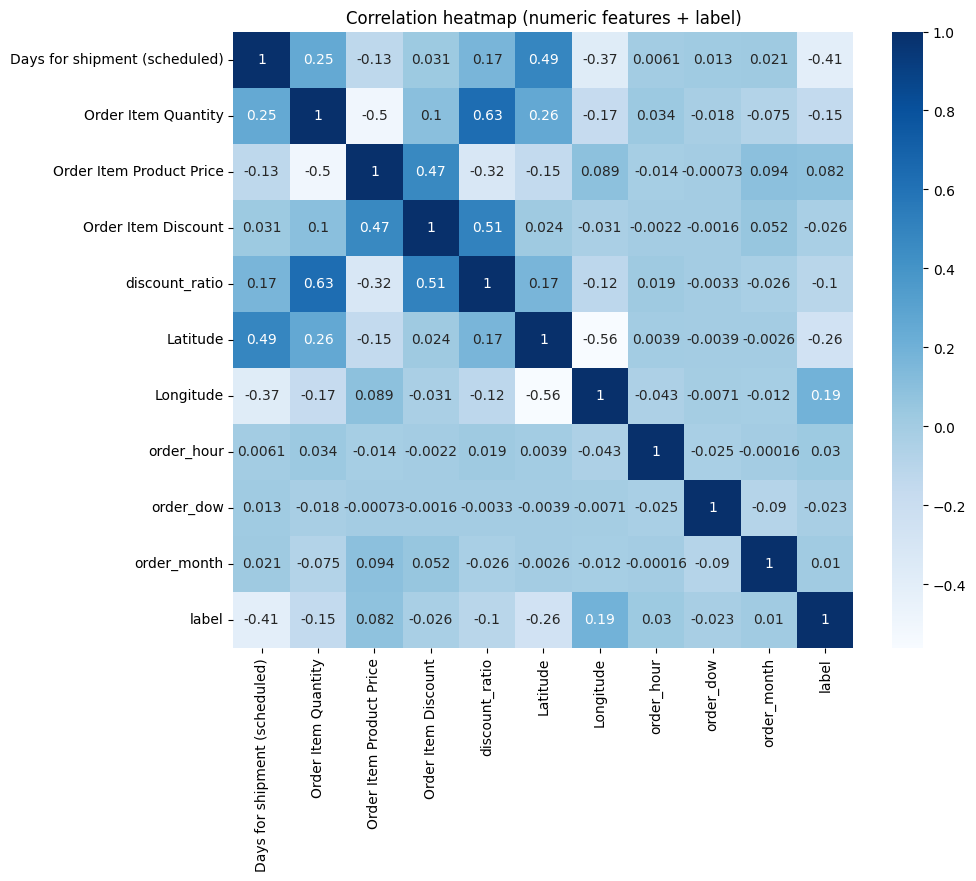

Late rate by Shipping Mode (top):
     Shipping Mode  late_rate
0     First Class   0.953225
1    Second Class   0.766328
2        Same Day   0.457430
3  Standard Class   0.380717
Plot error for Shipping Mode: xlabel() missing 1 required positional argument: 'xlabel'
Late rate by Order Region (top):
      Order Region  late_rate
0  Central Africa   0.579606
1      South Asia   0.562670
2     East Africa   0.559395
3  Western Europe   0.558486
4  South of  USA    0.557726
Plot error for Order Region: xlabel() missing 1 required positional argument: 'xlabel'


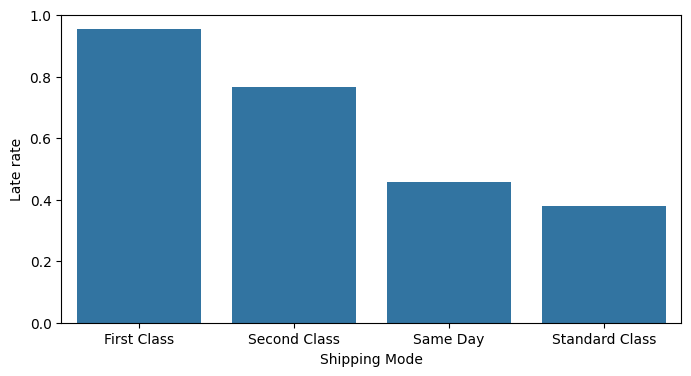

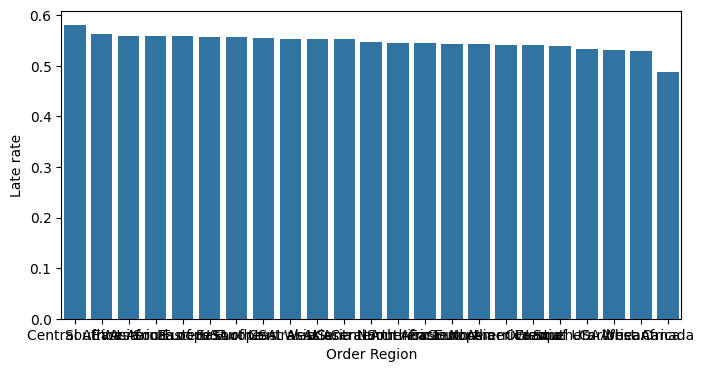

In [ ]:
# === Task 4: Visuals (correlations + categorical late-rate plots) ===
# Correlation heatmap for numeric features
num_cols = list(safe_cols_num)


try:
    pdf = safe_to_pandas(df_safe.select(*num_cols, "label"))
    if plt is not None:
        corr = pdf[num_cols + ["label"]].corr()
        plt.figure(figsize=(10, 8))
        if sns is not None:
            sns.heatmap(corr, annot=True, cmap="Blues")
        else:
            plt.imshow(corr, cmap="Blues"); plt.colorbar(); plt.xticks(range(len(corr)), corr.columns, rotation=90); plt.yticks(range(len(corr)), corr.index)
        plt.title("Correlation heatmap (numeric features + label)")
        plt.show()
    else:
        print("Matplotlib not available; skipping heatmap.")
except Exception as e:
    print("Correlation plot error:", e)

# Categorical late-rate bars
for cat in ["Shipping Mode", "Order Region"]:
    try:
        rate_df = (df_safe.groupBy(cat)
                   .agg(F.mean(F.col("label").cast("double")).alias("late_rate"))
                   .orderBy(F.desc("late_rate")))
        rate_pd = safe_to_pandas(rate_df)
        print(f"Late rate by {cat} (top):\n", rate_pd.head())
        if plt is not None:
            plt.figure(figsize=(8, 4))
            order = list(rate_pd.sort_values("late_rate", ascending=False)[cat])
            if sns is not None:
                sns.barplot(data=rate_pd, x=cat, y="late_rate", order=order,fill=True)
            else:
                plt.bar(rate_pd[cat], rate_pd["late_rate"])
                plt.xticks(rotation=30, ha="right")
            plt.ylabel("Late rate")
            plt.xlabel(labelpad=80)
            plt.figure(figsize=(15,8))
            plt.title(f"Late rate by {cat}")
            plt.tight_layout(); plt.show()
        else:
            print("Matplotlib not available; printing table only.")
    except Exception as e:
        print(f"Plot error for {cat}:", e)

In [18]:
# equivalent computation showing counts and fraction
rate_df = (
    df_safe.groupBy(cat)
           .agg(
               F.count(F.lit(1)).alias("n"),
               F.sum(F.col("label").cast("double")).alias("n_late")
           )
           .withColumn("late_rate", F.col("n_late") / F.col("n"))
)
rate_df.show()

+---------------+-----+-------+------------------+
|   Order Region|    n| n_late|         late_rate|
+---------------+-----+-------+------------------+
|   North Africa| 3232| 1762.0|0.5451732673267327|
|Southern Africa| 1157|  617.0| 0.533275713050994|
| Western Europe|27109|15140.0|0.5584861116234461|
|     US Center | 5887| 3252.0|0.5524036011550875|
|  South America|14935| 8111.0|0.5430867090726481|
|      Caribbean| 8318| 4415.0|0.5307766289973551|
|   West of USA | 7993| 4313.0|0.5395971475040661|
|        Oceania|10148| 5482.0|0.5402049664958612|
|   Central Asia|  553|  306.0|0.5533453887884268|
| South of  USA | 4045| 2256.0| 0.557725587144623|
|      West Asia| 6009| 3322.0|0.5528374105508405|
|     South Asia| 7731| 4350.0|0.5626697710516104|
|    East of USA| 6915| 3849.0|0.5566160520607375|
|    West Africa| 3696| 1953.0|0.5284090909090909|
| Southeast Asia| 9539| 5297.0|0.5552992976202956|
|Southern Europe| 9431| 5129.0|0.5438447672569187|
|   Eastern Asia| 7280| 3955.0|

In [5]:
# # === Optional: Categorical Cardinality Diagnostics ===
# from pyspark.sql import functions as F

# CARDINALITY_OHE_THRESHOLD = 50

# cat_cols_probe = [
#     "Shipping Mode", "Market", "Order Region", "Customer Segment",
#     "Department Id", "Category Id", "Product Category Id"
# ]

# cardinality = {}
# for c in cat_cols_probe:
#     cardinality[c] = df_safe.select(F.col(c)).distinct().count()

# ohe_cols_preview = [c for c in cat_cols_probe if cardinality.get(c, 0) <= CARDINALITY_OHE_THRESHOLD]
# idx_only_preview = [c for c in cat_cols_probe if c not in ohe_cols_preview]

# print("Distinct category counts:", cardinality)
# print("Will One-Hot Encode (<= threshold):", ohe_cols_preview)
# print("Will use index only (high-cardinality):", idx_only_preview)

Distinct category counts: {'Shipping Mode': 4, 'Market': 5, 'Order Region': 23, 'Customer Segment': 3, 'Department Id': 11, 'Category Id': 51, 'Product Category Id': 51}
Will One-Hot Encode (<= threshold): ['Shipping Mode', 'Market', 'Order Region', 'Customer Segment', 'Department Id']
Will use index only (high-cardinality): ['Category Id', 'Product Category Id']


In [19]:
# === Task 5: Preprocessing Pipeline (impute, encode, assemble) + Class Weights ===
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql import functions as F

# Base columns (safe)
cat_cols = [
    "Shipping Mode", "Market", "Order Region", "Customer Segment",
    "Department Id", "Category Id", "Product Category Id"
]
num_cols = [
    "Days for shipment (scheduled)", "Order Item Quantity", "Order Item Product Price",
    "Order Item Discount", "discount_ratio", "Latitude", "Longitude",
    "order_hour", "order_dow", "order_month"
]

# Impute numeric columns (median) (we rblace nan values)
imputer = Imputer(strategy="median", inputCols=num_cols, outputCols=[f"{c}__imp" for c in num_cols])
imputed_num_cols = [f"{c}__imp" for c in num_cols]

# Dynamically decide which categoricals to OHE vs index-only based on cardinality
CARDINALITY_OHE_THRESHOLD = 50
cardinality_map = {c: df_safe.select(F.col(c)).distinct().count() for c in cat_cols}
ohe_cols = [c for c, k in cardinality_map.items() if k <= CARDINALITY_OHE_THRESHOLD]
idx_only_cols = [c for c in cat_cols if c not in ohe_cols]
print("Category cardinalities:", cardinality_map)
print("OHE columns:", ohe_cols)
print("Index-only columns:", idx_only_cols)

# Index all categoricals
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}__idx", handleInvalid="keep") for c in cat_cols]
# One-hot encode only the low-cardinality group
encoders = [OneHotEncoder(inputCol=f"{c}__idx", outputCol=f"{c}__oh") for c in ohe_cols]

# Assemble features: use __oh for OHE cols, __idx for high-cardinality cols
assembler = VectorAssembler(
    inputCols=[f"{c}__oh" for c in ohe_cols] + [f"{c}__idx" for c in idx_only_cols] + imputed_num_cols,
    outputCol="features_raw")

scaler = StandardScaler(inputCol="features_raw", outputCol="features")

# Compute class weights to mitigate imbalance
counts = df_safe.groupBy("label").count().collect()
count_dict = {row["label"]: row["count"] for row in counts}
neg = float(count_dict.get(0, 1.0)); pos = float(count_dict.get(1, 1.0))
w_pos = neg / pos if pos > 0 else 1.0
df_weighted = df_safe.withColumn("weightCol", F.when(F.col("label") == 1, F.lit(w_pos)).otherwise(F.lit(1.0)))

print("Class counts:", count_dict, "| positive weight:", w_pos)
print("Preprocessing objects ready (imputer/indexers/encoders/assembler/scaler)")

Category cardinalities: {'Shipping Mode': 4, 'Market': 5, 'Order Region': 23, 'Customer Segment': 3, 'Department Id': 11, 'Category Id': 51, 'Product Category Id': 51}
OHE columns: ['Shipping Mode', 'Market', 'Order Region', 'Customer Segment', 'Department Id']
Index-only columns: ['Category Id', 'Product Category Id']
Class counts: {0: 81542, 1: 98977} | positive weight: 0.8238479646786627
Preprocessing objects ready (imputer/indexers/encoders/assembler/scaler)
Class counts: {0: 81542, 1: 98977} | positive weight: 0.8238479646786627
Preprocessing objects ready (imputer/indexers/encoders/assembler/scaler)


In [21]:
print(imputed_num_cols)

['Days for shipment (scheduled)__imp', 'Order Item Quantity__imp', 'Order Item Product Price__imp', 'Order Item Discount__imp', 'discount_ratio__imp', 'Latitude__imp', 'Longitude__imp', 'order_hour__imp', 'order_dow__imp', 'order_month__imp']


In [7]:
# === Task 6: Train/Test Split, Cross-Validation, and Metrics ===
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Optional: prototype on a sampled subset of training data to reduce memory/time
PROTOTYPE_FRACTION = None  # e.g., 0.5 to train on 50% of train set

# Split
train_df, test_df = df_weighted.randomSplit([0.8, 0.2], seed=42)
print("Train rows:", train_df.count(), "Test rows:", test_df.count())

if PROTOTYPE_FRACTION:
    train_df = train_df.sample(withReplacement=False, fraction=float(PROTOTYPE_FRACTION), seed=42)
    print("Using prototype training sample fraction:", PROTOTYPE_FRACTION, "→ rows:", train_df.count())

# Classifier with weightCol and memory-friendly defaults
rf = RandomForestClassifier(
    labelCol="label", featuresCol="features", weightCol="weightCol",
    numTrees=50, maxDepth=6, subsamplingRate=0.7, featureSubsetStrategy="sqrt",
    minInstancesPerNode=10, seed=42
)

pipeline = Pipeline(stages=[
    imputer,
    *indexers,
    *encoders,
    assembler,
    scaler,
    rf
])

# Compact param grid to limit CV workload
param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [50])
              .addGrid(rf.maxDepth, [6])
              .build())

eval_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=eval_auc, numFolds=3, parallelism=1, seed=42)

cv_model = cv.fit(train_df)

pred_test = cv_model.transform(test_df).cache()

# Metrics
auc = eval_auc.evaluate(pred_test)
acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(pred_test)
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(pred_test)
prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(pred_test)
rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(pred_test)

print({"AUC": auc, "Accuracy": acc, "F1": f1, "Precision": prec, "Recall": rec})

# Confusion matrix
pred_test.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

Train rows: 144625 Test rows: 35894


Train rows: 144625 Test rows: 35894


25/11/24 16:22:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/11/24 16:22:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Train rows: 144625 Test rows: 35894


25/11/24 16:22:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/11/24 16:22:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


{'AUC': 0.7570449402123385, 'Accuracy': 0.7165821585780353, 'F1': 0.7129094356652257, 'Precision': 0.7548742286401827, 'Recall': 0.7165821585780354}
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|14192|
|    0|       1.0| 1969|
|    1|       0.0| 8204|
|    1|       1.0|11529|
+-----+----------+-----+

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|14192|
|    0|       1.0| 1969|
|    1|       0.0| 8204|
|    1|       1.0|11529|
+-----+----------+-----+



Top grouped feature importances:
feat_48: 0.3642
feat_0: 0.2560
feat_2: 0.2032
feat_3: 0.0708
feat_1: 0.0644
feat_55: 0.0356
feat_53: 0.0008
feat_54: 0.0008
feat_57: 0.0004
feat_56: 0.0004
feat_51: 0.0003
feat_46: 0.0003
feat_52: 0.0003
feat_47: 0.0002
feat_50: 0.0002


Top grouped feature importances:
feat_48: 0.3642
feat_0: 0.2560
feat_2: 0.2032
feat_3: 0.0708
feat_1: 0.0644
feat_55: 0.0356
feat_53: 0.0008
feat_54: 0.0008
feat_57: 0.0004
feat_56: 0.0004
feat_51: 0.0003
feat_46: 0.0003
feat_52: 0.0003
feat_47: 0.0002
feat_50: 0.0002


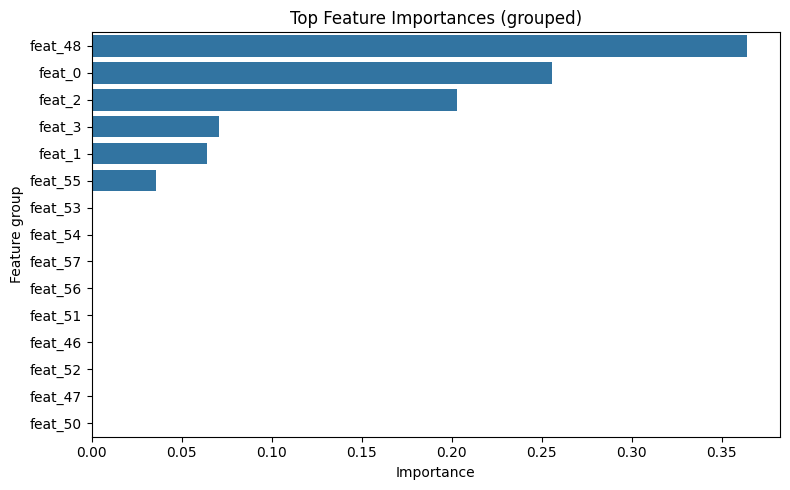

In [8]:
# === Task 7: Feature Importances (grouped) ===
from collections import defaultdict

best_pm = cv_model.bestModel  # PipelineModel
rf_model = None
for st in reversed(best_pm.stages):
    if hasattr(st, 'featureImportances'):
        rf_model = st
        break

if rf_model is None:
    print("RF model not found in pipeline stages.")
else:
    # Method 1: Try to extract attribute names from metadata (may fail)
    print("=" * 60)
    print("ATTEMPTING FEATURE NAME MAPPING...")
    print("=" * 60)
    
    feats_df = pred_test.select("features").limit(1)
    attrs = feats_df.schema["features"].metadata.get("ml_attr", {}).get("attrs", {})
    idx_to_name = {}
    for k in ["binary", "numeric", "nominal"]:
        for item in attrs.get(k, []):
            idx_to_name[item["idx"]] = item["name"]
    
    print(f"Metadata found {len(idx_to_name)} feature names\n")
    
    # If metadata is empty, build manual mapping from preprocessing
    if len(idx_to_name) == 0:
        print("⚠️  Metadata extraction failed. Building manual feature mapping...\n")
        idx_to_name = {}
        current_idx = 0
        
        # OHE features (low-cardinality categoricals)
        for cat in ohe_cols:
            # Get distinct values to estimate OHE dimension
            n_categories = df_safe.select(cat).distinct().count()
            for i in range(n_categories - 1):  # OHE creates n-1 columns
                idx_to_name[current_idx] = f"{cat}__oh_{i}"
                current_idx += 1
        
        # Index-only features (high-cardinality categoricals)
        for cat in idx_only_cols:
            idx_to_name[current_idx] = f"{cat}__idx"
            current_idx += 1
        
        # Imputed numeric features
        for num in num_cols:
            idx_to_name[current_idx] = f"{num}__imp"
            current_idx += 1
        
        print(f"✓ Manual mapping created for {len(idx_to_name)} features\n")
    
    # Show first 10 features for reference
    print("First 10 features in the vector:")
    for idx in sorted(idx_to_name.keys())[:10]:
        print(f"  Index {idx}: {idx_to_name.get(idx, 'UNKNOWN')}")
    print()
    
    # Extract importances
    importances = rf_model.featureImportances
    print(f"RandomForest has {len(importances)} feature importances\n")
    
    grouped = defaultdict(float)
    detailed = []
    for i, imp in enumerate(importances):
        if imp == 0.0:
            continue
        name = idx_to_name.get(i, f"feat_{i}")
        
        # Extract base feature name (remove suffixes)
        if "__oh" in name:
            base = name.split("__oh")[0]
        elif "__imp" in name:
            base = name.split("__imp")[0]
        elif "__idx" in name:
            base = name.split("__idx")[0]
        else:
            base = name
        
        grouped[base] += float(imp)
        detailed.append((i, name, float(imp), base))
    
    # Sort and display
    top_grouped = sorted(grouped.items(), key=lambda x: x[1], reverse=True)[:15]
    print("=" * 60)
    print("TOP 15 GROUPED FEATURE IMPORTANCES:")
    print("=" * 60)
    for k, v in top_grouped:
        print(f"{k:<40} {v:>8.4f} ({v*100:>5.2f}%)")
    print()
    
    # Show unmapped features warning
    unmapped = [i for i in range(len(importances)) if i not in idx_to_name]
    if unmapped:
        print(f"⚠️  WARNING: {len(unmapped)} feature indices not mapped (>= {len(idx_to_name)})")
        print(f"   This may indicate incomplete feature mapping.\n")
    
    # Detailed breakdown of top 3
    print("=" * 60)
    print("DETAILED BREAKDOWN OF TOP 3 FEATURES:")
    print("=" * 60)
    top_3_bases = [k for k, v in top_grouped[:3]]
    for base_name in top_3_bases:
        matching_feats = [d for d in detailed if d[3] == base_name]
        print(f"\n{base_name} (Total Importance: {grouped[base_name]:.4f})")
        print("  Sub-components:")
        for idx, full_name, imp, base in sorted(matching_feats, key=lambda x: x[2], reverse=True):
            print(f"    - {full_name:<40} {imp:>8.4f}")
    print()
    
    # Optional bar plot
    try:
        if plt is not None:
            labels, vals = zip(*top_grouped)
            plt.figure(figsize=(10, 6))
            if sns is not None:
                sns.barplot(x=list(vals), y=list(labels), palette="viridis")
            else:
                plt.barh(labels, vals, color="steelblue")
            plt.title("Top 15 Feature Importances (Grouped)", fontsize=14, fontweight='bold')
            plt.xlabel("Importance Score", fontsize=12)
            plt.ylabel("Feature Name", fontsize=12)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Importance plot error: {e}")

In [9]:
# === Task 8: Save Best Model and Metrics (with listing) ===
import os, json
import time

save_dir = os.environ.get("MODEL_DIR", "/src/models")
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "late_delivery_pipeline_safe")
metrics_path = os.path.join(save_dir, "metrics.json")

cv_model.bestModel.write().overwrite().save(model_path)
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump({
        "AUC": auc,
        "Accuracy": acc,
        "F1": f1,
        "Precision": prec,
        "Recall": rec
        
    }, f, indent=2)

# Brief wait then list directory contents for verification
time.sleep(1)
print("Saved model directory:", model_path)
print("Model directory contents:", os.listdir(model_path))
print("Metrics file:", metrics_path, "exists?", os.path.exists(metrics_path))

Saved model directory: /src/models/late_delivery_pipeline_safe
Model directory contents: ['metadata', 'stages']
Metrics file: /src/models/metrics.json exists? True
